<a href="https://colab.research.google.com/github/rg-smith/TEM-modeling/blob/main/notebooks/EM_forward_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/rg-smith/TEM-modeling.git

In [ ]:
!pip install simpeg

In [3]:
import os
os.chdir('TEM-modeling/notebooks')

In [4]:
import pandas as pd
import numpy as np
from utilities.gex_parser import parse_gex_file
import matplotlib.pyplot as plt

from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils import plot_1d_layer_model
import discretize

/content/TEM-modeling/notebooks/utilities/gex_parser.py:23: SyntaxWarning: invalid escape sequence '\d'
  id_search = re.search("\d+", line).span()
/content/TEM-modeling/notebooks/utilities/gex_parser.py:44: SyntaxWarning: invalid escape sequence '\w'
  elif (match:= re.search("Waveform\w+Point\d+", description)) is not None:
/content/TEM-modeling/notebooks/utilities/gex_parser.py:49: SyntaxWarning: invalid escape sequence '\d'
  elif (match:= re.search("GateTime\d+", description)) is not None:


In [5]:
# replace this path with the path of your .gex file, if different. This is an example tTEM .gex file from Julianne Robinson's thesis (2025)
gex_file = parse_gex_file('../data/20221003_TX43_tTEM33_RC2041.gex')

In [ ]:
print(gex_file)

In [29]:
# In general the location of the gates is
# gate_time = gate_centers + shift + delay
# The Gex file also tells us which gates the respective moments use
gate_centers = gex_file['General']['GateTimes']['center']

channel_info = gex_file['Channel1']
shift = channel_info['GateTimeShift']
delay = channel_info['MeaTimeDelay']
first_gate = channel_info['RemoveInitialGates']
last_gate = channel_info['NoGates']
lm_times = gate_centers[first_gate:last_gate] + shift + delay

channel_info = gex_file['Channel2']
shift = channel_info['GateTimeShift']
delay = channel_info['MeaTimeDelay']
first_gate = channel_info['RemoveInitialGates']
last_gate = channel_info['NoGates']
hm_times = gate_centers[first_gate:last_gate] + shift + delay

n_lm_gates = len(lm_times)
n_hm_gates = len(hm_times)

In [8]:
# get waveform from gex file
waves = gex_file['General']['Waveforms']
lm_wave_time = waves['LM']['time']
lm_wave_form = waves['LM']['form']
hm_wave_time = waves['HM']['time']
hm_wave_form = waves['HM']['form']

In [27]:
# We pad the locations of the Tx points with 0, to expand it from a 2D (x,y) pair to a 3D (x, y, z) pair.
# We also add another row because we will need to close the transmitter loop.
tx_shape = np.pad(gex_file['General']['TxLoopPoints'], (0, 1))
tx_shape[-1] = tx_shape[0]

rx_offset = gex_file['General']['RxCoilPosition1']

# gex file format uses negative number as above ground, while simpeg is the opposite. Flip sign to account for this
rx_offset[2] = rx_offset[2]*-1

In [10]:
# also let's grab the area
tx_area = gex_file['General']['TxLoopArea']

In [11]:
# Low moment:
rx_lm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_offset, lm_times, orientation='z'
)

lm_wave = tdem.sources.PiecewiseLinearWaveform(lm_wave_time, lm_wave_form)

src_lm = tdem.sources.LineCurrent(rx_lm, tx_shape, waveform=lm_wave)

In [12]:
# high moment
rx_hm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_offset, hm_times, orientation='z'
)

hm_wave = tdem.sources.PiecewiseLinearWaveform(hm_wave_time, hm_wave_form)

src_hm = tdem.sources.LineCurrent(rx_hm, tx_shape, waveform=hm_wave)

In [13]:
src_lm = tdem.sources.LineCurrent(rx_lm, tx_shape, waveform=lm_wave)

In [14]:
srv = tdem.Survey([src_lm, src_hm])

(1, 1000)

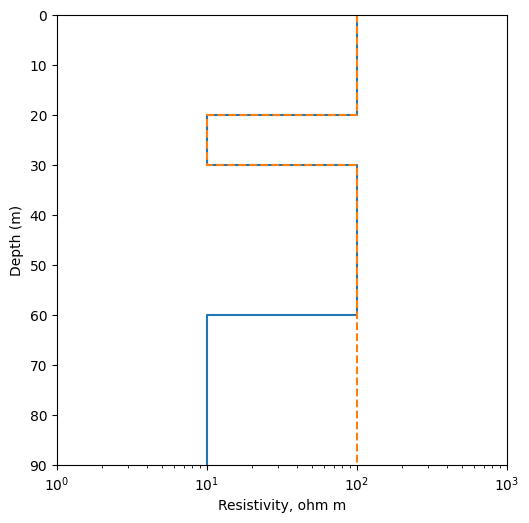

In [53]:
# resistivities and thicknesses to forward model
thicknesses1 = np.array([20,10,30])
resistivities1 = np.array([100,10,100,10])
conductivities1 = 1/resistivities1

thicknesses2 = np.array([20,10,30])
resistivities2 = np.array([100,10,100,100])
conductivities2 = 1/resistivities2

# plot resistivity model
ax = plot_1d_layer_model(thicknesses1,resistivities1)
plot_1d_layer_model(thicknesses2,resistivities2,linestyle='--',ax=ax)
ax.set_xlabel('Resistivity, ohm m')
ax.set_xlim([1,1000])

In [54]:
sim1 = tdem.Simulation1DLayered(srv, sigma=conductivities1, thicknesses=thicknesses1)
sim2 = tdem.Simulation1DLayered(srv, sigma=conductivities2, thicknesses=thicknesses2)

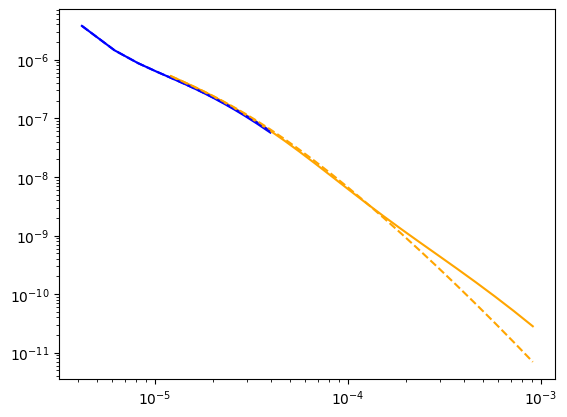

In [55]:
# get data from sim1
pre = -sim1.dpred(None)
pre_lm = pre[:n_lm_gates]
pre_hm = pre[n_lm_gates:]

# plot simulated data
plt.loglog(lm_times, pre_lm, 'blue')
plt.loglog(hm_times, pre_hm, 'orange')

# get data from sim2
pre = -sim2.dpred(None)
pre_lm = pre[:n_lm_gates]
pre_hm = pre[n_lm_gates:]

# plot simulated data
plt.loglog(lm_times, pre_lm, 'blue', linestyle='--')
plt.loglog(hm_times, pre_hm, 'orange', linestyle='--')